# Navigation Project with Deep Q-Learning Network 

## Import Libraries

Import standard and Unity Python libraries  

In [1]:
# Standard Python Libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque

# ML Library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Unity Library
from unityagents import UnityEnvironment

In [2]:
# Check if we can run the algo on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device Available:', device)

Device Available: cuda:0


## Unity Environment
Load the Unity environment the agent will learn to interact with. 
The agent has to learn to navigate and collect bananas in a large, square world. 

In [3]:
# With visual interface
# env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")

# No visual interface
env = UnityEnvironment(file_name="./Banana_Linux_NoVis/Banana.x86_64")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# Check Environment Specs
print(str(env))


Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 1. Check Brains
Environment contains **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
print('Brain Used: ',brain_name)
brain = env.brains[brain_name]

Brain Used:  BananaBrain


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

In [7]:
# examine the state space
state = env_info.vector_observations[0]
state_size = len(state)
print('States have length:', state_size)
print('States look like:\n', state)

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# number of agents in the environment
print('Number of agents:', len(env_info.agents))
print('Agent Number:', env_info.agents[0])

# examine the reward
reward = env_info.rewards[0]
print('Reward:', reward)


States have length: 37
States look like:
 [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
Number of actions: 4
Number of agents: 1
Agent Number: 776
Reward: 0.0


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, we will have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
# ################
# Random Actions #
# ################
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
for j in range(200):
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if j % 40 == 0:                                 # check interim score
        print("Score after {} steps: {}".format(j, score))
    if done:                                       # exit loop if episode finished
        break
    
print("Final Score: {}".format(score))

Score after 0 steps: 0.0
Score after 40 steps: 0.0
Score after 80 steps: 0.0
Score after 120 steps: 0.0
Score after 160 steps: 0.0
Final Score: 0.0


## 4. Agent
The agent implements a decaying epsilon-greedy policy with experience replay.

In [9]:
#  Hyperparameters for the Agent Learning process
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [10]:
# Define Agent Class 
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)        # Choose Optimizer

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


## 5. Experience Replay

In [11]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


## 5. Define Q Network

In [12]:
# Define QNetwork
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        input_size = state_size
        hidden_sizes = [150, 120, 60]                 # Number of Layers
        output_size = action_size

        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])

        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_sizes[:-1], hidden_sizes[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])

        self.output = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = state
        for each in self.hidden_layers:
            x = F.relu(each(x))
        x = self.output(x)
        return x


## 6. Define routine for the interaction between Agen and Environment


In [13]:
# Hyperparameters
train_mode = True  # Training Mode

n_episodes = 2000  # Max number of episodes
max_t = 1000       # Max number of timesteps per episode

eps_start = 1.0    # Starting value of epsilon, for epsilon-greedy action selection
eps_end = 0.01     # Minimum value of epsilon
eps_decay = 0.995  # Decay Factor

n_window = 100     # Trailing window for score
tgt_score = 15     # Target score

In [14]:
def Interact(env, agent, brain_name, train_mode=True, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, n_window=100, tgt_score=15):
    """Deep Q-Learning.
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """

    print('\rRunning for {} episodes with target score of {}'.format(n_episodes, tgt_score))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('\rUsing {}'.format(device))
    
    # Initialise
    scores = []                                             # list containing scores from each episode
    scores_window = deque(maxlen=n_window)                  # last 100 scores
    eps = eps_start                                         # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]    # reset the environment
        state = env_info.vector_observations[0]                    # get the current state
        score = 0
        
        for t in range(max_t):
            # Agent Selects Action #
            action = agent.act(state, eps)                         # Agent action
            
            # Agent Performs Action #
            env_info = env.step(action)[brain_name]                # Environment reacts
            next_state = env_info.vector_observations[0]           # get the next state
            reward = env_info.rewards[0]                           # get the reward
            done = env_info.local_done[0]                          # see if episode has finished
            
            # Agent Observes State #
            agent.step(state, action, reward, next_state, done)    # Agent observes new state
            state = next_state                                     # roll over the state to next time step
            score += reward                                        # update the score
            
            if done:
                break
        scores_window.append(score)        # save most recent score
        scores.append(score)               # save most recent score
        eps = max(eps_end, eps_decay*eps)  # decrease epsilon
        
        # Periodic Check
        if i_episode % n_window == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= tgt_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-n_window, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'Trained_Agent.pth')
            break
    return scores

## 7. Train Agent


In [15]:
# #######
# AGENT #
# #######
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# #############
# TRAIN AGENT #
# #############
scores = Interact(env, agent, brain_name, train_mode, n_episodes, max_t,\
                  eps_start, eps_end, eps_decay, n_window, tgt_score)


Running for 2000 episodes with target score of 15
Using cuda:0
Episode 100	Average Score: 0.56
Episode 200	Average Score: 3.56
Episode 300	Average Score: 6.73
Episode 400	Average Score: 9.69
Episode 500	Average Score: 12.90
Episode 600	Average Score: 13.85
Episode 700	Average Score: 14.33

Environment solved in 645 episodes!	Average Score: 15.02


## 8. Check Score

In [16]:
# Compute Rolling mean over last 100 episodes
rolling_mean = pd.Series(scores).rolling(100).mean()

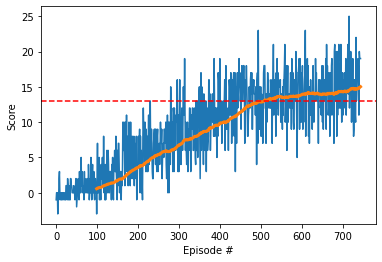

In [17]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(rolling_mean, lw=3)
plt.axhline(y=13, color='r', linestyle='dashed')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.savefig('Average_Score.pdf')

## 9. Play Smart Agent

In [18]:
# load the learned weights from file
agent.qnetwork_local.load_state_dict(torch.load('Trained_Agent.pth'))

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
for j in range(200):
    action = agent.act(state)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]    # get the next state
    reward = env_info.rewards[0]                    # get the reward
    done = env_info.local_done[0]                   # see if episode has finished
    score += reward                                 # update the score
    state = next_state                              # roll over the state to next time step
    if j % 40 == 0:                                 # check interim score
        print("Bananas collected after {} steps: {}".format(j, score))
    if done:
        break

print("Total Bananas: {}".format(score))


Bananas collected after 0 steps: 0.0
Bananas collected after 40 steps: 1.0
Bananas collected after 80 steps: 4.0
Bananas collected after 120 steps: 4.0
Bananas collected after 160 steps: 4.0
Total Bananas: 4.0


## Close Environment
When finished, you can close the environment.

In [19]:
env.close()